 WaveLabX example run
 CSV file      : wavedata.csv
 Sampling freq : 100.0 Hz
 Water depth   : 0.250 m
 Gauge pos     : (0.0, 0.6, 0.9)

Loaded 20000 samples per probe → record length ≈ 200.0 s



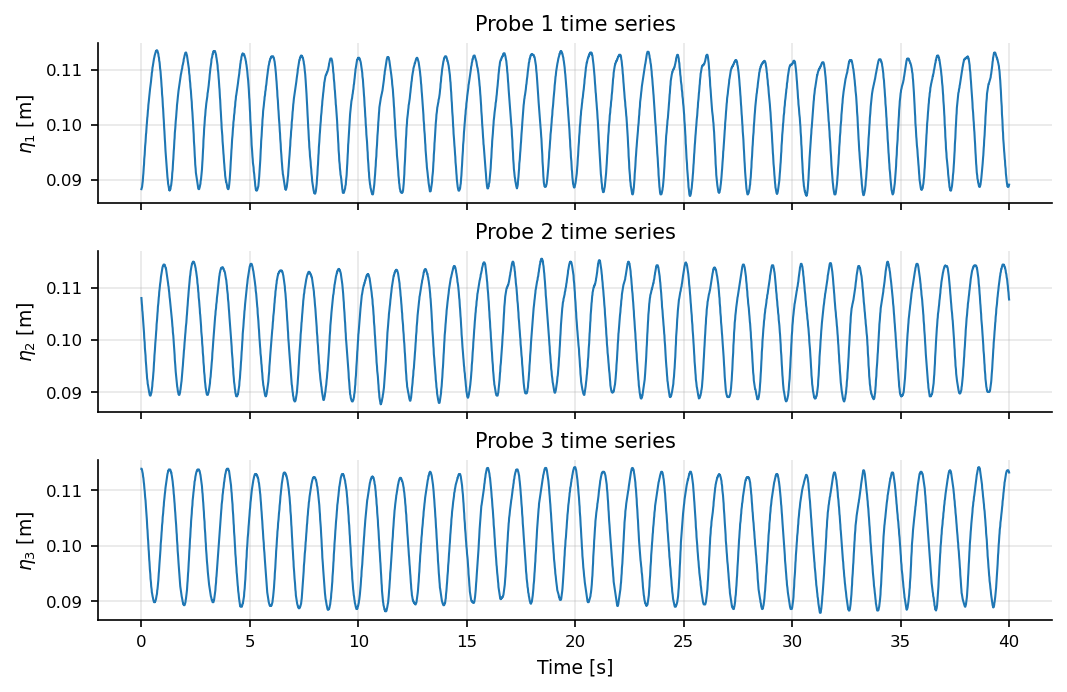

=== One-probe zero-crossing statistics (Probe 1) ===
Hs     :   0.0254
Hmean  :   0.0249
H1_10  :   0.0257
Hmax   :   0.0259
Tmean  :   1.3334
Ts     :   1.3312

=== Two-probe reflection analysis (Goda, Probes 2 & 3) ===
Hi (incident Hm0)  : 0.0350 m
Hr (reflected Hm0) : 0.0042 m
Kr = Hr/Hi         : 0.120

=== Three-probe array reflection analysis ===
Hi (incident Hm0)  : 0.0356 m
Hr (reflected Hm0) : 0.0045 m
refco = Hr/Hi      : 0.128
Htot (composite)   : 0.0346 m

Analysis complete. Time-series, 2-probe spectra, and 3-probe
spectra/time-series plots have been generated (if show_plots=True).


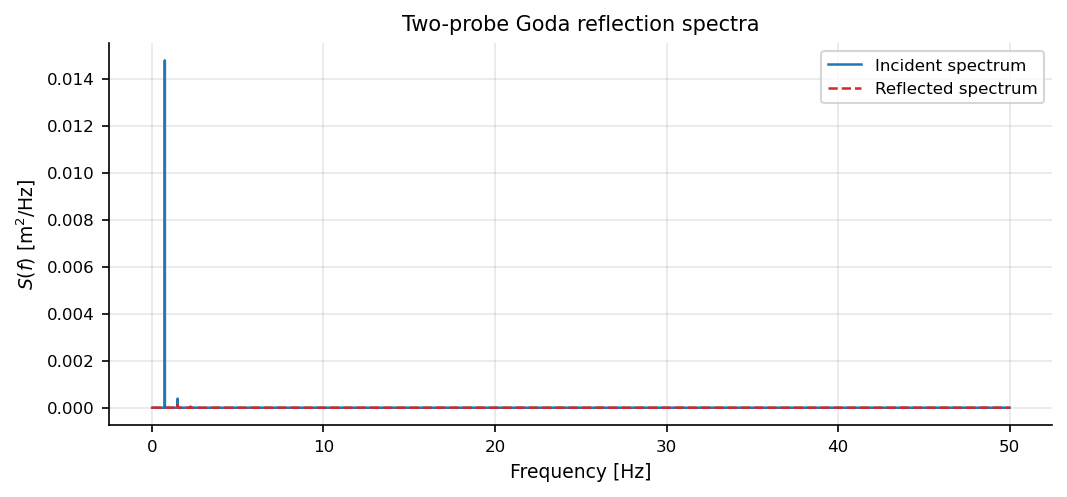

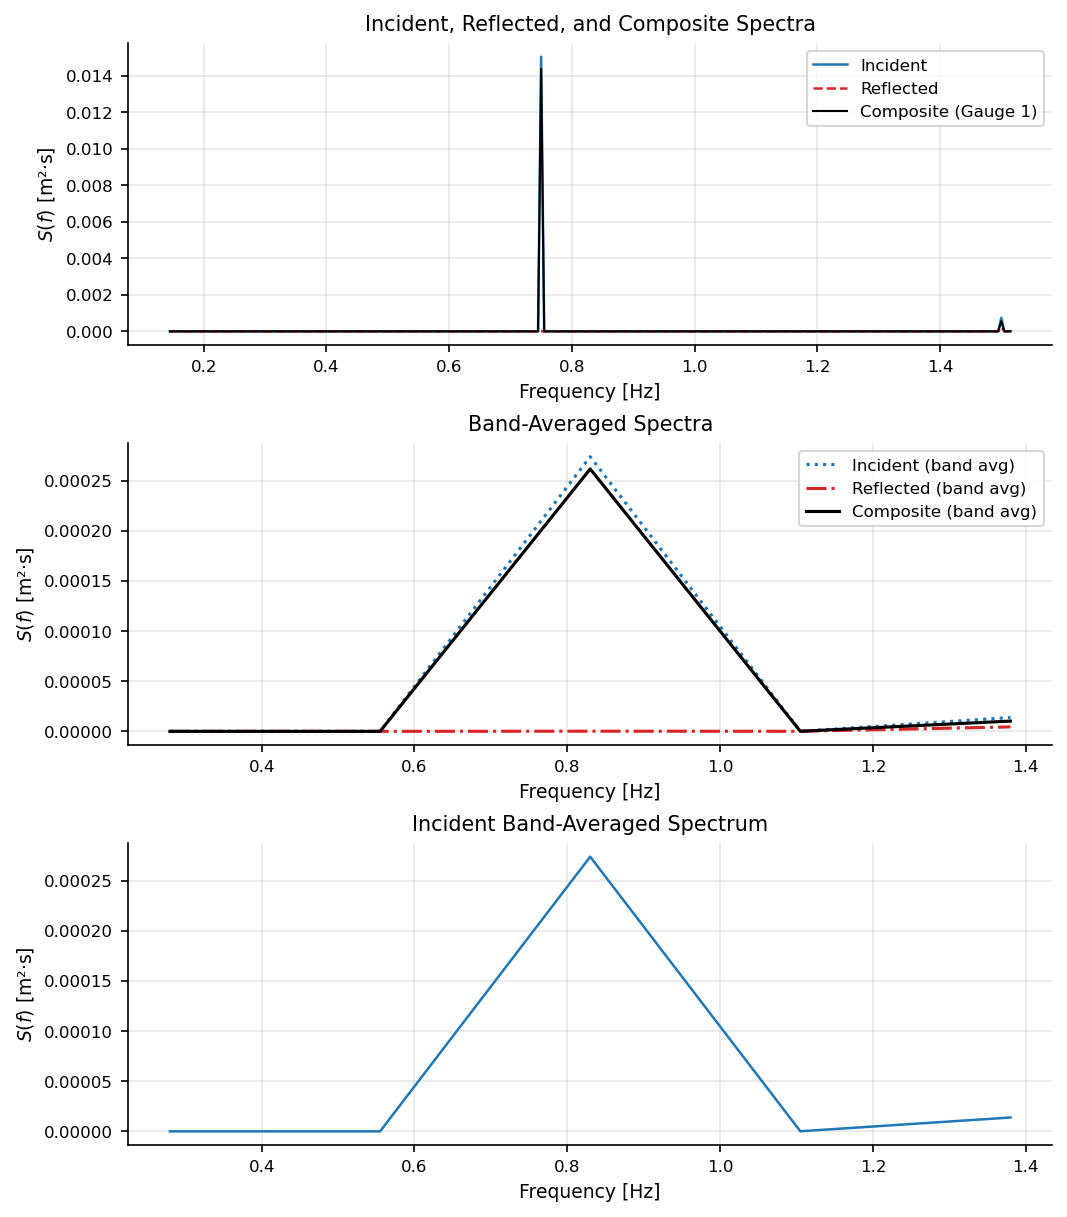

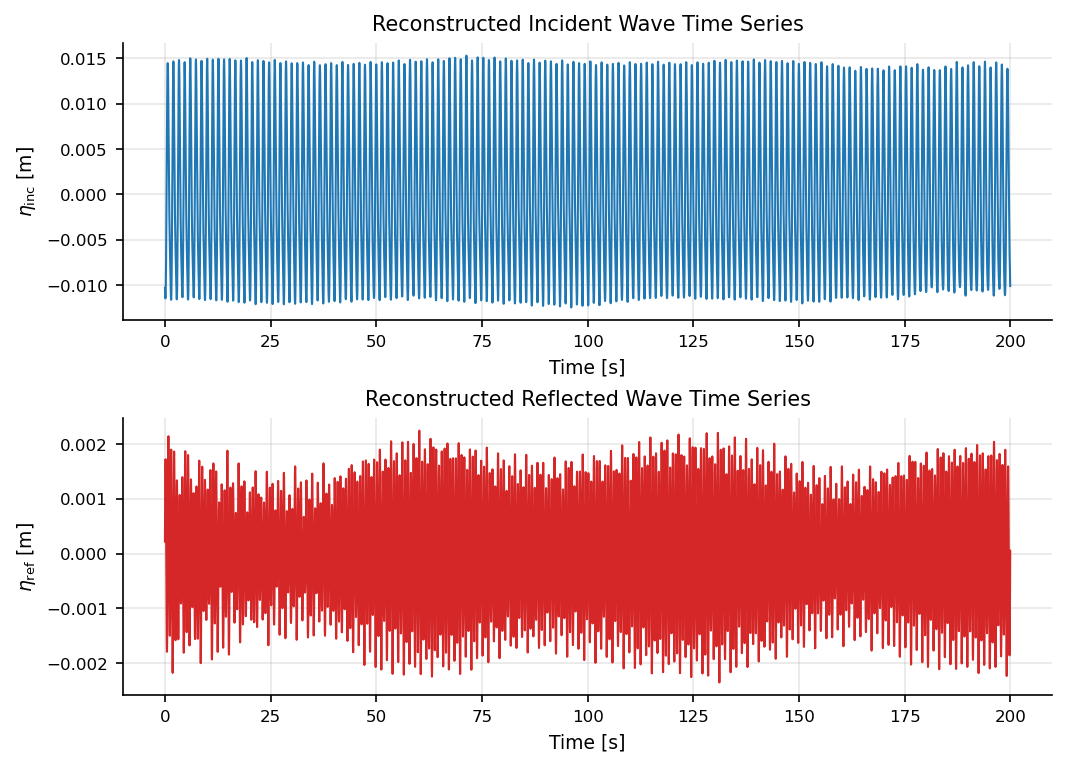

In [ ]:
"""
WaveLabX example: complete analysis of a three-probe dataset.

This script:
  1) Computes zero-crossing wave statistics from Probe 1.
  2) Performs two-probe Goda reflection analysis using Probes 2 & 3.
  3) Performs three-probe array reflection analysis using Probes 1, 2 & 3.

Plots produced:
  - From this example:
      • Time series of Probes 1, 2, 3 (stacked, 3×1)
  - From two_probe_goda (plot=True):
      • Incident vs reflected spectra S(f)
  - From three_probe_array (plot=True):
      • Detailed spectra (incident / reflected / composite)
      • Band-averaged spectra
      • Reconstructed incident / reflected time series

Run from the terminal:
    python run_wavelabx_example.py
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wavelabx import (
    zero_crossing,
    two_probe_goda,
    three_probe_array,
)


def plot_three_probe_timeseries(
    t: np.ndarray,
    eta1: np.ndarray,
    eta2: np.ndarray,
    eta3: np.ndarray,
    out_name: str = "wavelabx_timeseries",
    t_max: float = 40.0,
) -> None:
    """3×1 time-series plot for Probes 1–3."""

    # Global style similar to other WaveLabX plots
    plt.rcParams.update({
        "font.size": 9,
        "axes.labelsize": 9,
        "axes.titlesize": 10,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "figure.dpi": 150,
        "savefig.dpi": 300,
    })

    mask = t <= t_max  # show first t_max seconds for clarity

    fig, axes = plt.subplots(3, 1, figsize=(7.0, 4.5), sharex=True, constrained_layout=True)

    # --- Probe 1 ----------------------------------------------------
    axes[0].plot(t[mask], eta1[mask], linewidth=1.0)
    axes[0].set_ylabel(r"$\eta_1$ [m]")
    axes[0].set_title("Probe 1 time series")
    axes[0].grid(alpha=0.3)

    # --- Probe 2 ----------------------------------------------------
    axes[1].plot(t[mask], eta2[mask], linewidth=1.0)
    axes[1].set_ylabel(r"$\eta_2$ [m]")
    axes[1].set_title("Probe 2 time series")
    axes[1].grid(alpha=0.3)

    # --- Probe 3 ----------------------------------------------------
    axes[2].plot(t[mask], eta3[mask], linewidth=1.0)
    axes[2].set_ylabel(r"$\eta_3$ [m]")
    axes[2].set_xlabel("Time [s]")
    axes[2].set_title("Probe 3 time series")
    axes[2].grid(alpha=0.3)

    # Clean look: remove top/right spines
    for ax in axes:
        for spine in ["top", "right"]:
            ax.spines[spine].set_visible(False)

    # Save + show
    fig.savefig(f"{out_name}.png", bbox_inches="tight")
    # fig.savefig(f"{out_name}.pdf", bbox_inches="tight")  # enable if you want vector
    plt.show()
    plt.close(fig)


def run_wavelabx_example(
    csv_path: str = "wavedata.csv",
    fs: float = 100.0,
    h: float = 0.25,
    gpos: tuple[float, float, float] = (0.0, 0.6, 0.9),
    show_plots: bool = True,
):
    """
    Run a full WaveLabX analysis on a single three-probe dataset.

    Parameters
    ----------
    csv_path : str
        Path to CSV file with columns "Probe 1", "Probe 2", "Probe 3".
    fs : float
        Sampling frequency [Hz].
    h : float
        Water depth [m].
    gpos : tuple of float
        Gauge positions [m] along the flume: (x1, x2, x3).
        Example: (0.0, 0.6, 0.9)
    show_plots : bool
        If True, plotting inside two_probe_goda and three_probe_array
        will be activated, and the 3×1 time-series figure will be created.
    """

    print("========================================")
    print(" WaveLabX example run")
    print(" CSV file      :", csv_path)
    print(f" Sampling freq : {fs:.1f} Hz")
    print(f" Water depth   : {h:.3f} m")
    print(f" Gauge pos     : {gpos}")
    print("========================================\n")

    # --------------------------------------------------------
    # 1. Load data
    # --------------------------------------------------------
    df = pd.read_csv(csv_path)

    # Support both named and unnamed columns
    if all(n in df.columns for n in ["Probe 1", "Probe 2", "Probe 3"]):
        eta1 = df["Probe 1"].to_numpy(float)
        eta2 = df["Probe 2"].to_numpy(float)
        eta3 = df["Probe 3"].to_numpy(float)
    else:
        eta1 = df.iloc[:, 0].to_numpy(float)
        eta2 = df.iloc[:, 1].to_numpy(float)
        eta3 = df.iloc[:, 2].to_numpy(float)

    n = len(eta1)
    duration = n / fs
    t = np.arange(n) / fs  # time vector

    print(f"Loaded {n} samples per probe → record length ≈ {duration:.1f} s\n")

    # --------------------------------------------------------
    # 1a. Time-series figure (Probes 1–3)
    # --------------------------------------------------------
    if show_plots:
        plot_three_probe_timeseries(t, eta1, eta2, eta3)

    # --------------------------------------------------------
    # 2. Zero-crossing: Probe 1
    # --------------------------------------------------------
    stats, names = zero_crossing(eta1, fs)

    print("=== One-probe zero-crossing statistics (Probe 1) ===")
    for name in names:
        v = stats[name]
        if np.isnan(v):
            print(f"{name:6s} : NaN")
        else:
            print(f"{name:6s} : {v:8.4f}")
    print()

    # --------------------------------------------------------
    # 3. Two-probe Goda method: Probes 2 & 3
    # --------------------------------------------------------
    eta23 = np.column_stack([eta2, eta3])

    ref2 = two_probe_goda(
        eta23,
        fs=fs,
        h=h,
        gpos=(gpos[1], gpos[2]),  # (0.6, 0.9)
        plot=show_plots,
    )

    print("=== Two-probe reflection analysis (Goda, Probes 2 & 3) ===")
    print(f"Hi (incident Hm0)  : {ref2['Hi']:.4f} m")
    print(f"Hr (reflected Hm0) : {ref2['Hr']:.4f} m")
    print(f"Kr = Hr/Hi         : {ref2['Kr']:.3f}")
    print()

    # --------------------------------------------------------
    # 4. Three-probe array method: Probes 1, 2, 3
    # --------------------------------------------------------
    eta123 = np.column_stack([eta1, eta2, eta3])

    ref3 = three_probe_array(
        eta123,
        fs=fs,
        h=h,
        gpos=gpos,
        plot=show_plots,
    )

    print("=== Three-probe array reflection analysis ===")
    print(f"Hi (incident Hm0)  : {ref3['Hi']:.4f} m")
    print(f"Hr (reflected Hm0) : {ref3['Hr']:.4f} m")
    print(f"refco = Hr/Hi      : {ref3['refco']:.3f}")
    print(f"Htot (composite)   : {ref3['Htot']:.4f} m")
    print()

    print("Analysis complete. Time-series, 2-probe spectra, and 3-probe")
    print("spectra/time-series plots have been generated (if show_plots=True).")


if __name__ == "__main__":
    run_wavelabx_example(
        csv_path="wavedata.csv",
        fs=100.0,
        h=0.25,
        gpos=(0.0, 0.6, 0.9),
        show_plots=True,
    )


## Using the patched WaveLabX code

This notebook is updated to:
- confirm **which WaveLabX package** Jupyter is importing (local repo vs installed copy),
- surface the new **conditioning** and **retained-energy** diagnostics,
- keep outputs consistent with the SoftwareX reviewer comments.

**Tip:** after pulling new code, use **Kernel → Restart & Run All** to avoid cached imports.


In [ ]:
import wavelabx, inspect
print("WaveLabX loaded from:", wavelabx.__file__)

from wavelabx import (
    compute_wavelength,
    two_probe_goda,
    three_probe_array,
    reflection_analysis,
)
print("two_probe_goda source:", inspect.getsourcefile(two_probe_goda))
print("three_probe_array source:", inspect.getsourcefile(three_probe_array))


In [1]:
# --- Synthetic Validation Notebook Version ---
import numpy as np
import matplotlib.pyplot as plt

from wavelabx import compute_wavelength, two_probe_goda, three_probe_array


# === Synthetic wave parameters ===
Hm0_true_i = 0.04     # incident wave height (m)
Hm0_true_r = 0.006    # reflected wave height (m)
Kr_true = Hm0_true_r / Hm0_true_i

T = 1.30              # peak period (s)
fs = 100.0            # sampling frequency
dt = 1/fs
N = 20000
t = np.arange(N) * dt

h = 0.25               # depth (m)
Lp = compute_wavelength(h, T)    # compute theoretical wavelength


# === Define probe positions ===
x1 = 0.0
x2 = 0.6
x3 = 0.9

# === Build synthetic wave signals ===
omega = 2 * np.pi / T
k = 2 * np.pi / Lp

eta_i = (Hm0_true_i / 2) * np.cos(omega * t - k * x1)
eta_r = (Hm0_true_r / 2) * np.cos(omega * t + k * x1)


# --- Compute the true spectral Hm0 from the amplitudes actually used ---
Ai = Hm0_true_i / 2    # amplitude used in time series
Ar = Hm0_true_r / 2

m0_i = 0.5 * Ai**2
m0_r = 0.5 * Ar**2

Hm0_spec_true_i = 4 * np.sqrt(m0_i)
Hm0_spec_true_r = 4 * np.sqrt(m0_r)

Kr_true = Hm0_spec_true_r / Hm0_spec_true_i



eta1 = eta_i + eta_r

eta2 = (Hm0_true_i / 2) * np.cos(omega * t - k * x2) + \
       (Hm0_true_r / 2) * np.cos(omega * t + k * x2)

eta3 = (Hm0_true_i / 2) * np.cos(omega * t - k * x3) + \
       (Hm0_true_r / 2) * np.cos(omega * t + k * x3)


# === Run the two-probe method for the valid pair (2,3) ===
# two_probe_goda expects a (N, 2) array containing the two probe time series
eta23 = np.column_stack([eta2, eta3])
res23 = two_probe_goda(eta23, fs=fs, h=h, gpos=(x2, x3), plot=False)
print("\n--- Two-probe diagnostics (2-3) ---")
print("Retained energy fraction:", res23.get("retained_energy_fraction"))
cond23 = res23.get("cond")
bad23 = res23.get("bad_cond")
if cond23 is not None:
    import numpy as _np
    print("Max condition number:", float(_np.nanmax(cond23)))
if bad23 is not None:
    import numpy as _np
    print("Masked frequency fraction:", float(_np.mean(bad23)))

# === Run the three-probe method ===
# three_probe_array expects a (N, 3) array with probes in columns
eta123 = np.column_stack([eta1, eta2, eta3])
res3 = three_probe_array(eta123, fs=fs, h=h, gpos=(x1, x2, x3), plot=False)
print("\n--- Three-probe diagnostics (1-2-3) ---")
print("Retained energy fraction:", res3.get("retained_energy_fraction"))
print("Valid index range:", res3.get("valid_index_range"))
cond_pair = res3.get("cond_pair")
bad_pair = res3.get("bad_cond_pair")
if cond_pair is not None:
    import numpy as _np
    print("Max condition number across pairs:", float(_np.nanmax(cond_pair)))
if bad_pair is not None:
    import numpy as _np
    print("Masked fraction (avg across pairs):", float(_np.mean(bad_pair)))



# === Print results ===
print("=== Validation using synthetic sinusoidal waves ===\n")


print(f"True Incident Hm0 (spec) = {Hm0_spec_true_i:.4f} m")
print(f"Recovered (2–3)          = {res23['Hi']:.4f} m")
print(f"Relative Error (2–3)     = {(res23['Hi']-Hm0_spec_true_i)/Hm0_spec_true_i*100:.2f}%\n")

print(f"True Reflected Hm0 (spec)= {Hm0_spec_true_r:.4f} m")
print(f"Recovered (2–3)          = {res23['Hr']:.4f} m")
print(f"Relative Error (2–3)     = {(res23['Hr']-Hm0_spec_true_r)/Hm0_spec_true_r*100:.2f}%\n")

print(f"True Kr                  = {Kr_true:.3f}")
print(f"Recovered (2–3) Kr       = {res23['Kr']:.3f}")
print(f"Relative Error (2–3)     = {(res23['Kr']-Kr_true)/Kr_true*100:.2f}%\n")




=== Validation using synthetic sinusoidal waves ===

True Incident Hm0 (spec) = 0.0566 m
Recovered (2–3)          = 0.0566 m
Relative Error (2–3)     = 0.07%

True Reflected Hm0 (spec)= 0.0085 m
Recovered (2–3)          = 0.0085 m
Relative Error (2–3)     = 0.58%

True Kr                  = 0.150
Recovered (2–3) Kr       = 0.151
Relative Error (2–3)     = 0.51%




--- Spectral 'true' values used for validation ---
True Incident Hm0 (spec) = 0.0566 m
True Reflected Hm0 (spec)= 0.0085 m


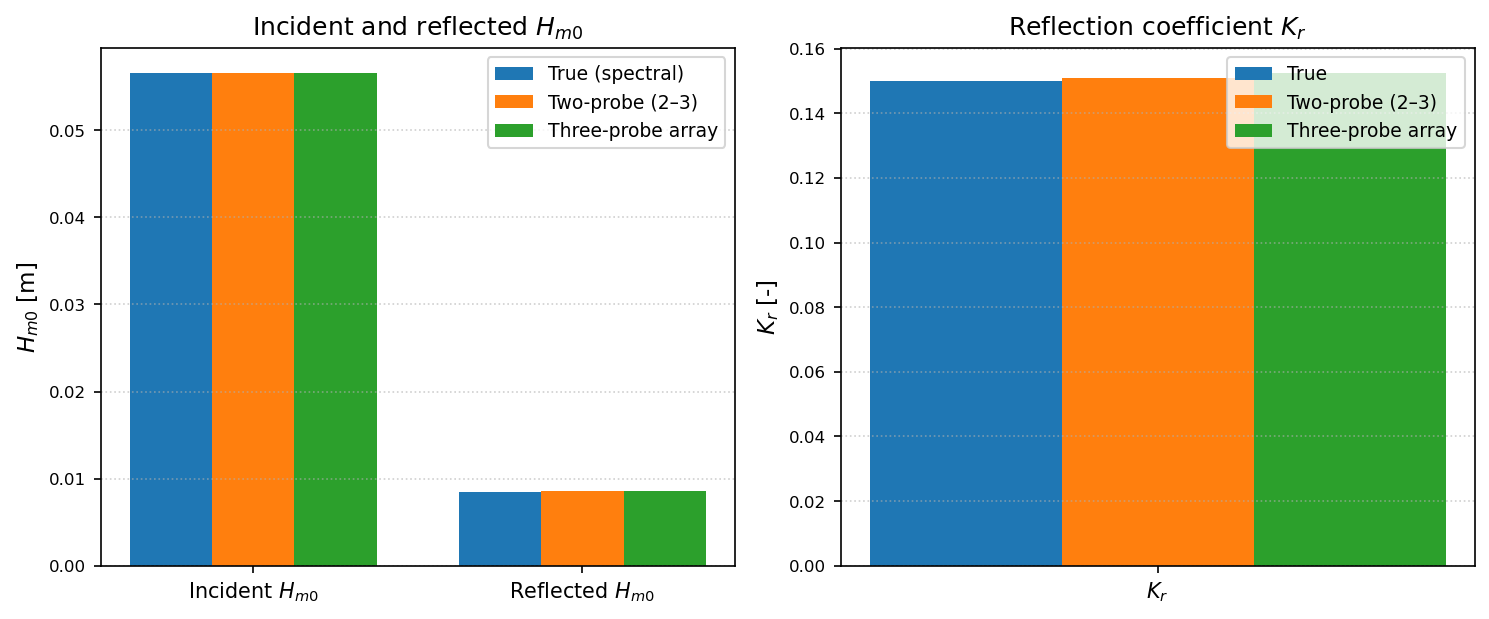

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Compute spectral "true" Hm0 (consistent with WaveLabX outputs) -----
Hm0_true_i_spec = np.sqrt(2.0) * Hm0_true_i
Hm0_true_r_spec = np.sqrt(2.0) * Hm0_true_r

print("\n--- Spectral 'true' values used for validation ---")
print(f"True Incident Hm0 (spec) = {Hm0_true_i_spec:.4f} m")
print(f"True Reflected Hm0 (spec)= {Hm0_true_r_spec:.4f} m")

# --- 2. Prepare data for plotting ------------------------------------------
labels = ['Incident $H_{m0}$', 'Reflected $H_{m0}$']

true_vals   = [Hm0_true_i_spec,       Hm0_true_r_spec]
two23_vals  = [res23['Hi'],           res23['Hr']]
three_vals  = [res3['Hi'],            res3['Hr']]

trueKr    = Kr_true
two23Kr   = res23['Kr']
threeKr   = res3['refco']

# --- 3. Create combined 2-panel figure -------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.2))

# ---- Left: Hm0 comparison --------------------------------------------------
x = np.arange(len(labels))
width = 0.25

ax1.bar(x - width, true_vals,  width, label='True (spectral)')
ax1.bar(x,         two23_vals, width, label='Two-probe (2–3)')
ax1.bar(x + width, three_vals, width, label='Three-probe array')

ax1.set_ylabel('$H_{m0}$ [m]', fontsize=11)
ax1.set_title('Incident and reflected $H_{m0}$', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=10)
ax1.legend(fontsize=9)
ax1.grid(axis='y', linestyle=':', alpha=0.6)

# ---- Right: Kr comparison --------------------------------------------------
x2 = np.arange(1)  # single group
width2 = 0.25

ax2.bar(x2 - width2, [trueKr],   width2, label='True')
ax2.bar(x2,          [two23Kr],  width2, label='Two-probe (2–3)')
ax2.bar(x2 + width2, [threeKr],  width2, label='Three-probe array')

ax2.set_ylabel('$K_r$ [-]', fontsize=11)
ax2.set_title('Reflection coefficient $K_r$', fontsize=12)
ax2.set_xticks(x2)
ax2.set_xticklabels(['$K_r$'], fontsize=10)
ax2.legend(fontsize=9)
ax2.grid(axis='y', linestyle=':', alpha=0.6)

fig.tight_layout()
fig.savefig("validation_synthetic.png", dpi=300, bbox_inches='tight')
plt.show()
